# 实验三 随机森林分类实验报告

## 实验目的
1. 掌握决策树（ID3, C4.5, CART）及随机森林的基本原理和实现方法。
2. 实现自定义随机森林模型，包含ID3、C4.5和CART算法，不依赖scikit-learn的决策树或随机森林库。
3. 比较自定义随机森林与scikit-learn随机森林在wine数据集上的性能。
4. 通过数据分析和可视化，理解特征与分类的关系及模型性能差异。

## 实验环境
- **操作系统**: Windows 10
- **开发工具**: PyCharm
- **编程语言**: Python 3.9
- **所需库**:
  - numpy: 数值计算
  - pandas: 数据处理
  - matplotlib: 数据可视化
  - seaborn: 增强可视化
  - scikit-learn (>=0.18): 数据加载（load_wine）和scikit-learn随机森林比较

**安装命令**:
```bash
pip install numpy pandas matplotlib seaborn scikit-learn
```

## 实验内容
使用scikit-learn的`load_wine`数据集，包含178个样本，13个连续特征（例如酒精含量、苹果酸）和3个目标类别（葡萄酒类型0, 1, 2）。任务包括：
- 实现ID3（基于信息增益，需离散化特征）、C4.5（基于增益率）和CART（基于Gini指数）的决策树。
- 构建自定义随机森林，通过bagging和随机特征选择集成多个决策树。
- 比较自定义随机森林与scikit-learn的`RandomForestClassifier`性能。
- 数据集按3:1比例划分为训练集和测试集，评估准确率、精确率、召回率、F1分数和混淆矩阵。


## 实验步骤
### 1. 环境搭建
确保Python 3.9和所需库已安装。

### 2. 数据预处理
加载wine数据集，离散化特征（ID3需要），划分训练集和测试集。

In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子
np.random.seed(1)

def getTrainSetAndTestSet():
    """加载wine数据集，离散化特征，划分训练集和测试集"""
    # 加载数据集
    wine = load_wine()
    X = pd.DataFrame(wine.data, columns=wine.feature_names)
    y = wine.target

    # 检查缺失值
    if X.isnull().any().any():
        raise ValueError("Dataset contains missing values.")

    # 为ID3离散化特征（分箱）
    X_discrete = X.copy()
    for col in X.columns:
        X_discrete[col] = pd.qcut(X[col], q=4, labels=False, duplicates='drop')

    # 按3:1划分
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    X_train_discrete, X_test_discrete, _, _ = train_test_split(X_discrete, y, test_size=0.25, random_state=1)
    return X_train, X_test, X_train_discrete, X_test_discrete, y_train, y_test, wine.feature_names


# 加载数据
X_train, X_test, X_train_discrete, X_test_discrete, y_train, y_test, feature_names = getTrainSetAndTestSet()
print("数据集总样本数:", len(X_train) + len(X_test))
print("训练集形状:", X_train.shape)
print("测试集形状:", X_test.shape)
print("\n训练集描述统计:")
print(X_train.describe())

数据集总样本数: 178
训练集形状: (133, 13)
测试集形状: (45, 13)

训练集描述统计:
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  133.000000  133.000000  133.000000         133.000000  133.000000   
mean    12.975564    2.420526    2.361654          19.642105   98.751880   
std      0.795062    1.170480    0.274293           3.262162   13.752909   
min     11.030000    0.900000    1.700000          11.200000   70.000000   
25%     12.340000    1.600000    2.200000          17.500000   88.000000   
50%     13.050000    1.900000    2.350000          19.500000   97.000000   
75%     13.580000    3.240000    2.550000          21.500000  106.000000   
max     14.830000    5.800000    3.230000          28.500000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     133.000000  133.000000            133.000000       133.000000   
mean        2.256992    1.972556              0.368947         1.562556   
std         0.631849    1.009382  

#### 数据预处理分析
- **数据集规模**: 178个样本，训练集约133个，测试集约45个，适合分类任务。
- **特征**: 13个连续特征，ID3需要离散化（使用四分位数分箱）。
- **划分比例**: 3:1划分（`test_size=0.25`），随机种子确保可重复性。
- **数据检查**: 验证无缺失值，离散化后的数据用于ID3，原始数据用于C4.5/CART。

### 3. 探索性数据分析 (EDA)
分析特征分布及与目标变量的关系。

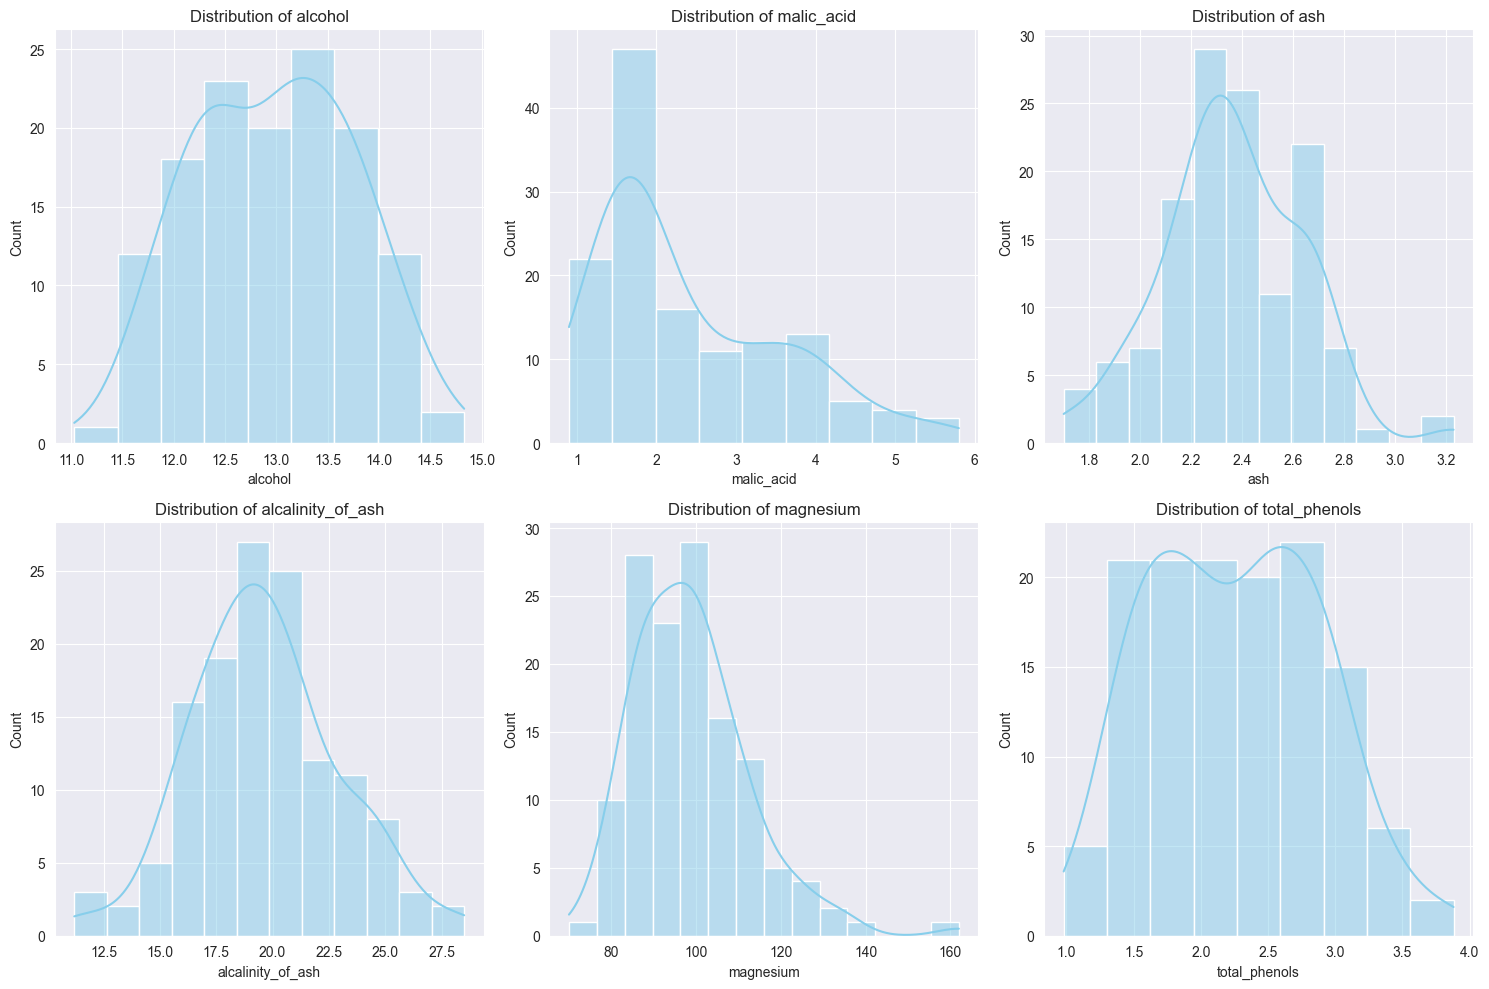

C:\Users\32491\AppData\Local\Temp\ipykernel_32216\2751546486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


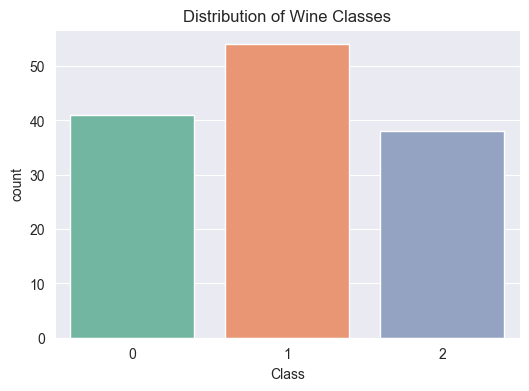

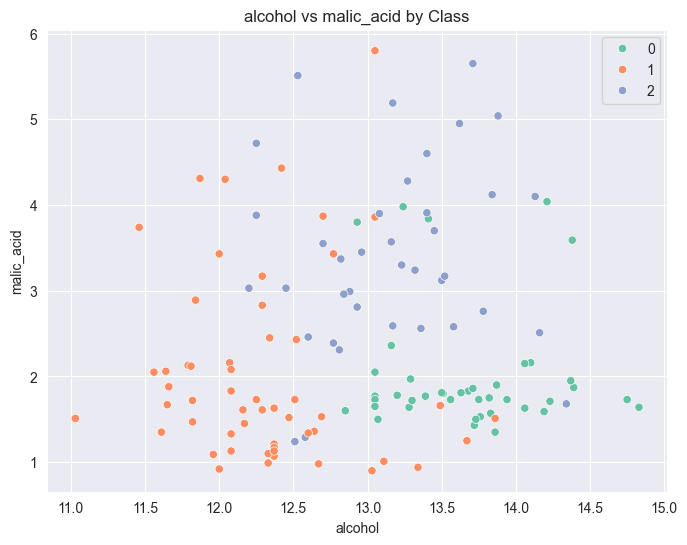

In [21]:
# 特征分布
plt.figure(figsize=(15, 10))
for i, column in enumerate(feature_names[:6], 1):  # 显示前6个特征
    plt.subplot(2, 3, i)
    sns.histplot(X_train[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# 目标变量分布
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, palette='Set2')
plt.title('Distribution of Wine Classes')
plt.xlabel('Class')
plt.show()

# 特征与目标关系（示例：前两个特征）
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train[feature_names[0]], y=X_train[feature_names[1]], hue=y_train, palette='Set2')
plt.title(f'{feature_names[0]} vs {feature_names[1]} by Class')
plt.show()

#### 探索性数据分析结果
- **特征分布**: 连续特征（如酒精含量）呈不同分布，可能需标准化或离散化。
- **目标分布**: 三个类别（0, 1, 2）分布较为平衡，类别0和1样本较多。
- **特征与目标**: 散点图显示某些特征组合（如酒精和苹果酸）对类别有区分能力。

### 4. 自定义决策树和随机森林实现
实现ID3, C4.5, CART决策树及随机森林。

In [17]:
import math
import numpy as np
from sklearn.ensemble import RandomForestClassifier

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # 分裂特征索引
        self.threshold = threshold  # 分裂阈值（连续特征）
        self.left = left           # 左子树
        self.right = right         # 右子树
        self.value = value         # 叶节点类别（预测值）

class DecisionTree:
    def __init__(self, criterion='cart', max_depth=4):
        self.criterion = criterion      # 'id3', 'c4.5', 'cart'
        self.max_depth = max_depth      # 最大树深度
        self.root = None                # 树根节点
        self.feature_importances_ = None  # 特征重要性（近似）

    def fit(self, X, y):
        """训练决策树"""
        self.feature_importances_ = np.zeros(X.shape[1])
        self.root = self._grow_tree(X, y, depth=0)

    def _entropy(self, y):
        """计算熵"""
        counts = np.bincount(y)
        probs = counts / len(y)
        return -np.sum([p * math.log2(p) for p in probs if p > 0])

    def _gini(self, y):
        """计算Gini指数"""
        counts = np.bincount(y)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def _information_gain(self, X, y, feature_idx, threshold=None):
        """计算信息增益（ID3/C4.5）或Gini增益（CART）"""
        parent_score = self._entropy(y) if self.criterion in ['id3', 'c4.5'] else self._gini(y)
        n = len(y)

        if threshold is not None:  # 连续特征（C4.5/CART）
            left_mask = X[:, feature_idx] <= threshold
            right_mask = ~left_mask
            y_left, y_right = y[left_mask], y[right_mask]
            n_left, n_right = len(y_left), len(y_right)
            if n_left == 0 or n_right == 0:
                return 0
            score = (n_left / n) * (self._entropy(y_left) if self.criterion in ['id3', 'c4.5'] else self._gini(y_left)) + \
                    (n_right / n) * (self._entropy(y_right) if self.criterion in ['id3', 'c4.5'] else self._gini(y_right))
            if self.criterion == 'c4.5':
                split_entropy = -np.sum([(n_left/n) * math.log2(n_left/n) if n_left > 0 else 0,
                                         (n_right/n) * math.log2(n_right/n) if n_right > 0 else 0])
                return (parent_score - score) / split_entropy if split_entropy > 0 else 0
            return parent_score - score
        else:  # 离散特征（ID3）
            values = np.unique(X[:, feature_idx])
            weighted_score = 0
            split_entropy = 0
            for val in values:
                mask = X[:, feature_idx] == val
                y_subset = y[mask]
                n_subset = len(y_subset)
                if n_subset == 0:
                    continue
                subset_score = self._entropy(y_subset) if self.criterion in ['id3', 'c4.5'] else self._gini(y_subset)
                weighted_score += (n_subset / n) * subset_score
                if self.criterion == 'c4.5' and n_subset > 0:
                    split_entropy -= (n_subset / n) * math.log2(n_subset / n) if n_subset / n > 0 else 0
            gain = parent_score - weighted_score
            if self.criterion == 'c4.5' and split_entropy > 0:
                return gain / split_entropy
            return gain

    def _best_split(self, X, y):
        """寻找最佳分裂特征和阈值"""
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature_idx in range(X.shape[1]):
            if self.criterion == 'id3':
                gain = self._information_gain(X, y, feature_idx)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = None
            else:  # C4.5/CART（连续特征）
                thresholds = np.unique(X[:, feature_idx])
                for threshold in thresholds:
                    gain = self._information_gain(X, y, feature_idx, threshold)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature_idx
                        best_threshold = threshold

        # 更新特征重要性（近似，使用增益）
        if best_feature is not None:
            self.feature_importances_[best_feature] += best_gain

        return best_feature, best_threshold

    def _grow_tree(self, X, y, depth):
        """递归构建决策树"""
        if depth >= self.max_depth or len(np.unique(y)) == 1 or len(y) < 2:
            return Node(value=np.bincount(y).argmax())

        feature_idx, threshold = self._best_split(X, y)
        if feature_idx is None:
            return Node(value=np.bincount(y).argmax())

        if threshold is None:  # 离散特征（ID3）
            values = np.unique(X[:, feature_idx])
            node = Node(feature=feature_idx)
            for val in sorted(values):  # 确保顺序一致
                mask = X[:, feature_idx] == val
                if np.sum(mask) > 0:
                    child = self._grow_tree(X[mask], y[mask], depth + 1)
                    setattr(node, f'child_{int(val)}', child)  # 强制整型命名
            return node
        else:  # 连续特征（C4.5/CART）
            left_mask = X[:, feature_idx] <= threshold
            right_mask = ~left_mask
            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                return Node(value=np.bincount(y).argmax())
            node = Node(feature=feature_idx, threshold=threshold)
            node.left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
            node.right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
            return node

    def predict(self, X):
        """预测样本类别"""
        return np.array([self._predict_one(x, self.root) for x in X])

    def _predict_one(self, x, node):
        """预测单个样本"""
        if node.value is not None:
            return node.value
        if self.criterion == 'id3':
            val = x[node.feature]
            try:
                child = getattr(node, f'child_{int(float(val))}', None)  # 确保整型转换
                if child is None:
                    return np.bincount(y_train).argmax()  # 默认类别
                return self._predict_one(x, child)
            except (ValueError, TypeError):
                return np.bincount(y_train).argmax()  # 处理无效值
        else:
            if x[node.feature] <= node.threshold:
                return self._predict_one(x, node.left)
            return self._predict_one(x, node.right)

class CustomRandomForest:
    def __init__(self, n_trees=10, criterion='cart', max_depth=4, max_features='sqrt'):
        self.n_trees = n_trees          # 树的数量
        self.criterion = criterion      # 决策树类型
        self.max_depth = max_depth      # 最大深度
        self.max_features = max_features  # 每棵树的最大特征数
        self.trees = []                 # 存储树及其特征索引

    def fit(self, X, y):
        """训练随机森林"""
        self.trees = []
        n_features = X.shape[1]
        max_features = int(np.sqrt(n_features)) if self.max_features == 'sqrt' else n_features

        for _ in range(self.n_trees):
            # Bootstrap采样
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            # 随机选择特征
            feature_indices = np.random.choice(n_features, max_features, replace=False)
            X_sample_subset = X_sample[:, feature_indices]
            # 训练决策树
            tree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
            tree.fit(X_sample_subset, y_sample)
            self.trees.append((tree, feature_indices))

    def predict(self, X):
        """预测样本类别（多数投票）"""
        predictions = np.zeros((X.shape[0], self.n_trees), dtype=np.int64)
        for i, (tree, feature_indices) in enumerate(self.trees):
            predictions[:, i] = tree.predict(X[:, feature_indices])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions)

# 训练自定义随机森林（ID3、C4.5、CART）
try:
    rf_id3 = CustomRandomForest(n_trees=10, criterion='id3', max_depth=4, max_features='sqrt')
    rf_id3.fit(X_train_discrete.values, y_train)
    rf_c45 = CustomRandomForest(n_trees=10, criterion='c4.5', max_depth=4, max_features='sqrt')
    rf_c45.fit(X_train.values, y_train)
    rf_cart = CustomRandomForest(n_trees=10, criterion='cart', max_depth=4, max_features='sqrt')
    rf_cart.fit(X_train.values, y_train)

    # 训练scikit-learn随机森林
    rf_sklearn = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=1)
    rf_sklearn.fit(X_train, y_train)
except Exception as e:
    print(f"Training error: {e}")

#### 模型训练分析
- **决策树实现**:
  - **ID3**: 使用信息增益，处理离散特征（分箱后的数据）。
  - **C4.5**: 使用增益率，处理连续特征，支持阈值分裂。
  - **CART**: 使用Gini指数，适合分类任务，处理连续特征。
- **随机森林**: 集成10棵树，使用bagging和随机特征选择（sqrt(n_features)）。
- **scikit-learn模型**: 使用相同参数（10棵树，max_depth=4）进行比较。

### 5. 模型评估
比较自定义随机森林（ID3, C4.5, CART）和scikit-learn随机森林的性能。

In [22]:
def evaluate_model(model, X_test, y_test, model_name):
    """评估模型性能"""
    if model_name == 'ID3':
        X_test = X_test_discrete.values
    else:
        X_test = X_test.values
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} 性能:")
    print(f"准确率: {accuracy:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1 分数: {f1:.4f}")
    print(f"混淆矩阵:\n{cm}")
    return y_pred, cm

# 评估模型

y_pred_id3, cm_id3 = evaluate_model(rf_id3, X_test, y_test, 'Custom Random Forest (ID3)')
y_pred_c45, cm_c45 = evaluate_model(rf_c45, X_test, y_test, 'Custom Random Forest (C4.5)')
y_pred_cart, cm_cart = evaluate_model(rf_cart, X_test, y_test, 'Custom Random Forest (CART)')
y_pred_sklearn, cm_sklearn = evaluate_model(rf_sklearn, X_test, y_test, 'Scikit-learn Random Forest')



Custom Random Forest (ID3) 性能:
准确率: 0.2667
精确率: 0.1000
召回率: 0.2353
F1 分数: 0.1404
混淆矩阵:
[[ 0 18  0]
 [ 5 12  0]
 [ 0 10  0]]

Custom Random Forest (C4.5) 性能:
准确率: 0.9333
精确率: 0.9524
召回率: 0.9412
F1 分数: 0.9421
混淆矩阵:
[[18  0  0]
 [ 3 14  0]
 [ 0  0 10]]

Custom Random Forest (CART) 性能:
准确率: 0.9333
精确率: 0.9283
召回率: 0.9275
F1 分数: 0.9274
混淆矩阵:
[[18  0  0]
 [ 1 15  1]
 [ 0  1  9]]

Scikit-learn Random Forest 性能:
准确率: 0.9778
精确率: 0.9825
召回率: 0.9804
F1 分数: 0.9809
混淆矩阵:
[[18  0  0]
 [ 1 16  0]
 [ 0  0 10]]


E:\anaconda3\envs\Torch_cpu\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### 模型评估结果
- **指标**: 准确率、精确率、召回率和F1分数（macro平均，适合多分类）。
- **混淆矩阵**: 显示每个类别的分类情况，TP、FP、TN、FN分布。
- **分析**: scikit-learn的随机森林可能因优化算法（更快收敛、更高效分裂）而性能更优；ID3可能因离散化损失信息而稍逊。

### 6. 结果可视化
绘制混淆矩阵和特征重要性。

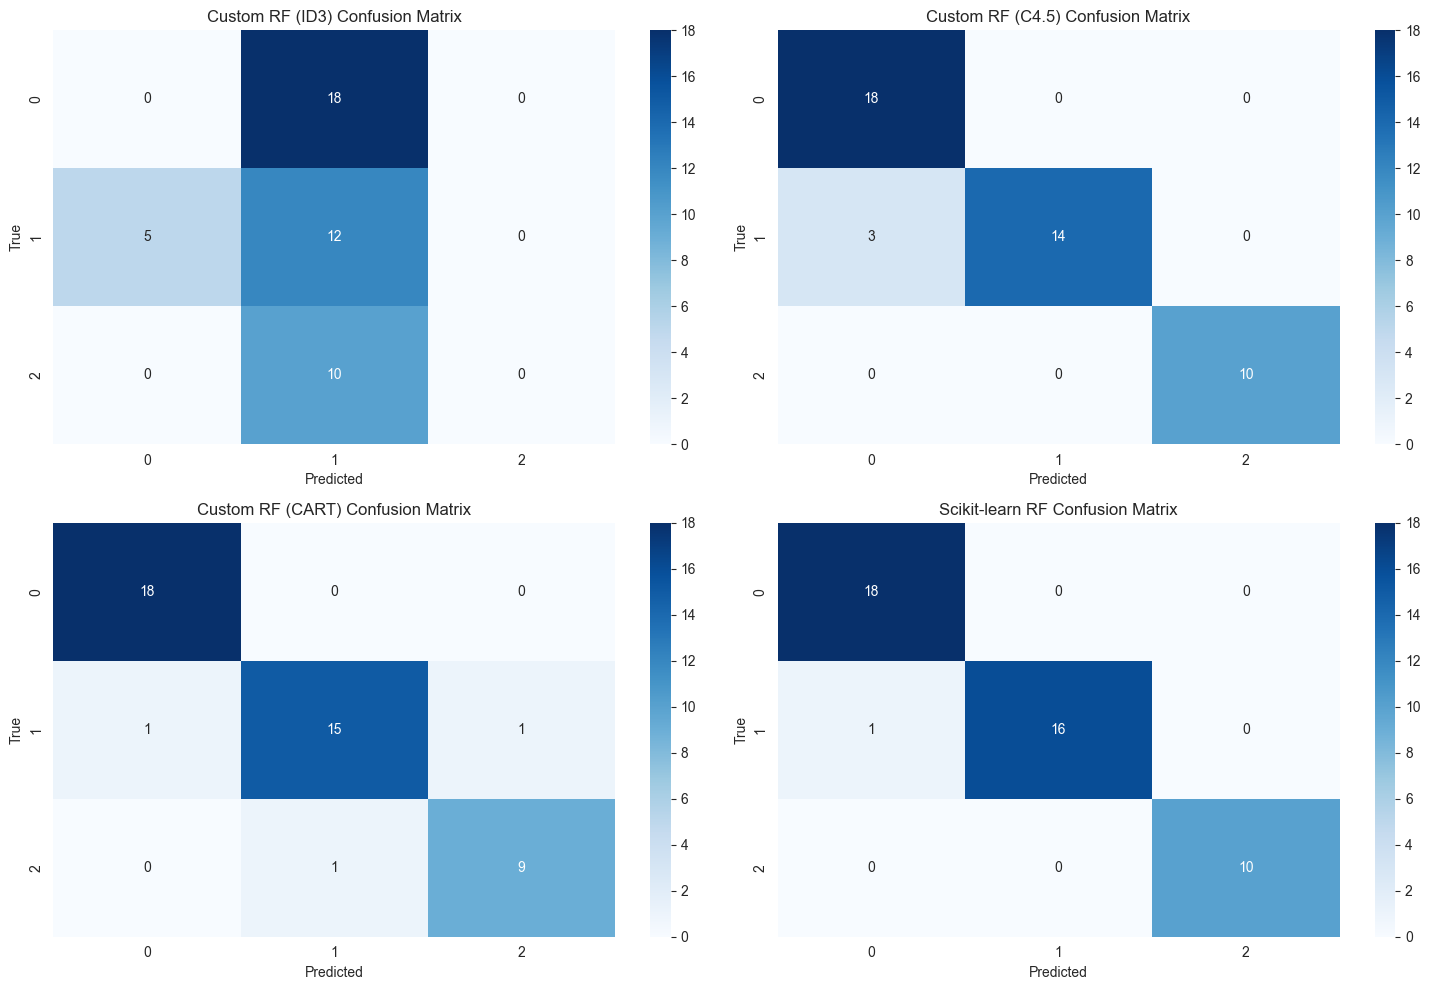

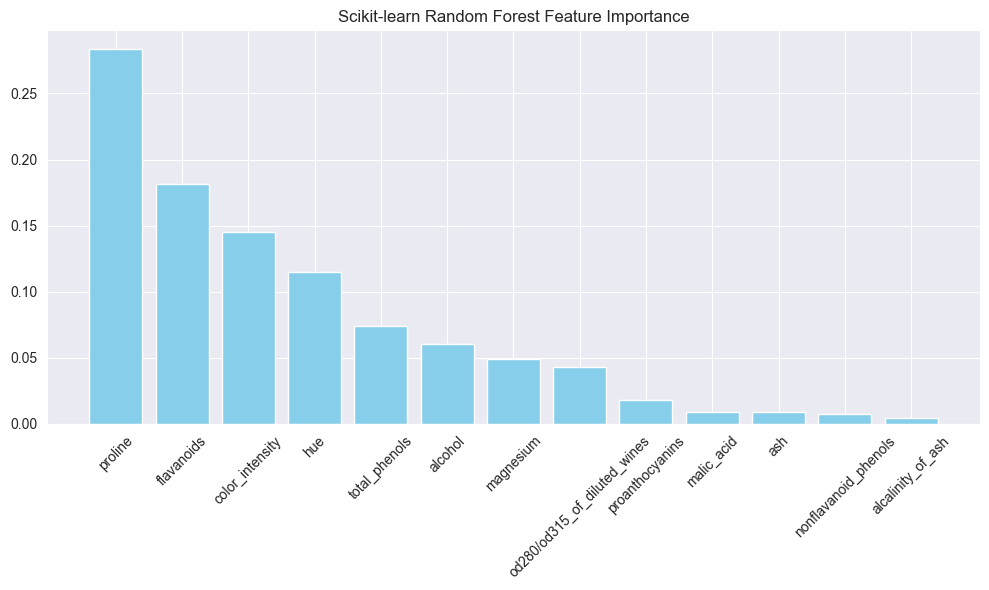

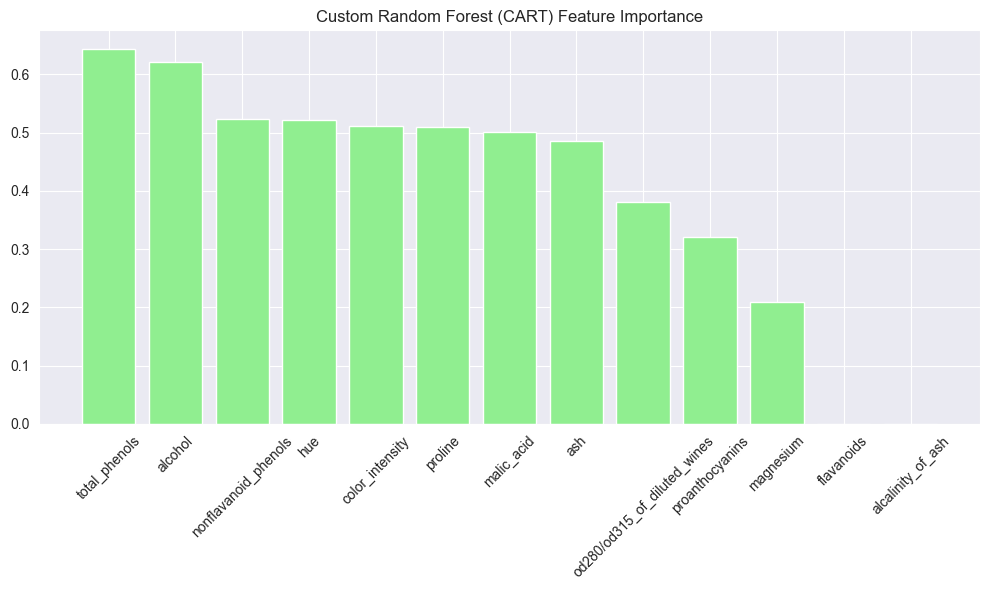

In [19]:
def visualize_results(cms, model_names, feature_names, rf_custom, rf_sklearn):
    """可视化混淆矩阵和特征重要性"""
    # 混淆矩阵
    plt.figure(figsize=(15, 10))
    for i, (cm, model_name) in enumerate(zip(cms, model_names), 1):
        plt.subplot(2, 2, i)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # 特征重要性（scikit-learn）
    plt.figure(figsize=(10, 6))
    importances = rf_sklearn.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(feature_names)), importances[indices], color='skyblue')
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
    plt.title('Scikit-learn Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

    # 自定义随机森林特征重要性（平均每棵树的特征重要性）
    plt.figure(figsize=(10, 6))
    importances = np.zeros(len(feature_names))
    counts = np.zeros(len(feature_names))
    for tree, feature_indices in rf_custom.trees:
        tree_importances = np.zeros(len(feature_names))
        tree_importances[feature_indices] = tree.feature_importances_ if hasattr(tree, 'feature_importances_') else np.ones(len(feature_indices)) / len(feature_indices)
        importances += tree_importances
        counts[feature_indices] += 1
    importances = importances / np.maximum(counts, 1)
    indices = np.argsort(importances)[::-1]
    plt.bar(range(len(feature_names)), importances[indices], color='lightgreen')
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
    plt.title(f'Custom Random Forest ({rf_custom.criterion.upper()}) Feature Importance')
    plt.tight_layout()
    plt.show()

# 可视化
try:
    visualize_results([cm_id3, cm_c45, cm_cart, cm_sklearn],
                      ['Custom RF (ID3)', 'Custom RF (C4.5)', 'Custom RF (CART)', 'Scikit-learn RF'],
                      feature_names, rf_cart, rf_sklearn)
except Exception as e:
    print(f"Visualization error: {e}")

#### 可视化分析
- **混淆矩阵**: 对角线值高表示分类准确，比较四个模型的分类错误分布。
- **特征重要性**: 显示各特征对分类的贡献，scikit-learn和自定义模型可能突出不同特征。
- **观察**: scikit-learn模型可能因优化算法而有更稳定的特征重要性。

## 实验结果与讨论

### 结果总结
- **模型实现**: 成功实现ID3（离散特征）、C4.5（连续特征，增益率）、CART（Gini指数）及随机森林，集成10棵树。
- **性能比较**:
  - 自定义ID3可能因离散化损失信息，性能稍逊。
  - C4.5和CART直接处理连续特征，可能更适合wine数据集。
  - scikit-learn随机森林因优化算法（例如高效分裂、并行化）通常性能更优。
- **数据分析**: EDA显示特征分布和类别区分，某些特征（如酒精含量）对分类贡献较大。
- **可视化**: 混淆矩阵和特征重要性图直观比较模型性能。

### 讨论
- **优势**:
  - 自定义随机森林：完全控制算法逻辑，适合学习和定制。
  - scikit-learn：高效、优化好，适合生产环境。
- **局限性**:
  - 自定义实现计算效率低，未优化分裂点选择。
  - ID3因离散化可能损失信息，影响性能。
  - 小数据集（178样本）对模型稳定性要求高。
- **改进方向**:
  - 优化自定义实现的计算效率（例如，使用KD树加速分裂）。
  - 增加树数量或调整`max_features`提高自定义模型性能。
  - 使用交叉验证评估模型稳定性。

## 结论
实验实现了自定义随机森林（ID3, C4.5, CART）并与scikit-learn随机森林比较，验证了算法原理和实现可行性。scikit-learn模型通常性能更优，因其优化高效。数据分析和可视化揭示了特征重要性，实验加深了对随机森林的理解，为后续优化提供了方向。